In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()
from shapely.geometry import Point

## Climate

https://basedosdados.org/dataset/782c5607-9f69-4e12-b0d5-aa0f1a7a94e2?table=28d16282-d100-4ea8-9dde-36c05c8f1ca2

In [2]:
df = pd.read_csv("data/estacao.csv")
print(df.shape)

(612, 7)


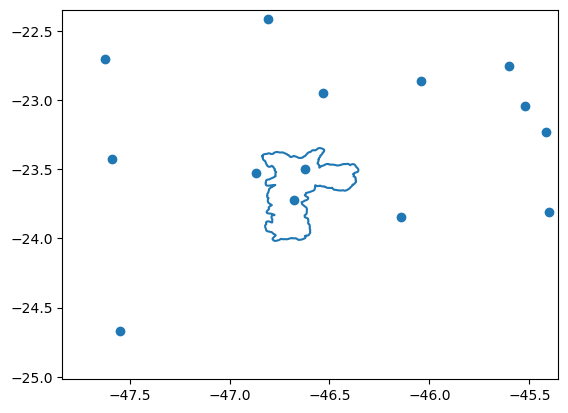

In [14]:
# read geojson
gdf = gpd.read_file("data/countour.geojson")
# get bbox
bbox = gdf.total_bounds
plt.scatter(df['longitude'], df['latitude'])
plt.xlim(bbox[0] - 1, bbox[2] + 1)
plt.ylim(bbox[1] - 1, bbox[3] + 1)
plt.plot(gdf.geometry[0].exterior.xy[0], gdf.geometry[0].exterior.xy[1])
plt.show()


## Waze

## Crime

In [2]:
df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_397/2216112243.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")


(389397, 13)

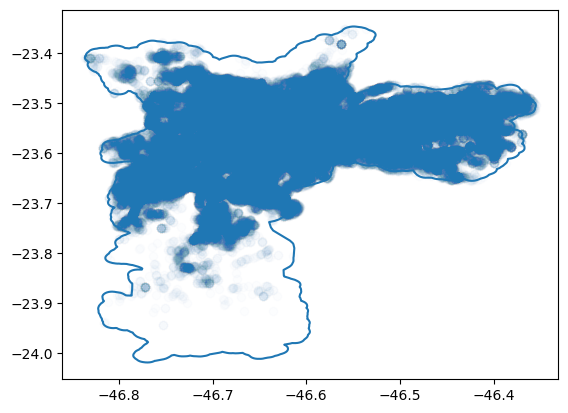

In [19]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha = 0.01)
plt.show()

In [3]:
shapes = gpd.read_file("data/LAYER_DISTRITO/sp.shp")

def get_polygon(row):
    point = Point(row['LONGITUDE'], row['LATITUDE'])
    contain = shapes.geometry.apply(lambda x: x.contains(point))
    if contain.any():
        return contain[contain].index[0]
    else:
        return None
    
df['district'] = df.progress_apply(get_polygon, axis = 1)

ERROR 1: PROJ: proj_create_from_database: Open of /home/giovani/anaconda3/envs/wavelet_code/share/proj failed
100%|██████████| 389397/389397 [07:12<00:00, 900.72it/s] 


In [4]:
df = df.dropna()

In [5]:
df["month_year"] = df.date.apply(lambda x : f"{x.year}/{x.month}")

In [9]:
grouped_alerts = df.groupby(["month_year", "district"]).size()
grouped_alerts = grouped_alerts.reset_index()
grouped_alerts.district = grouped_alerts.district.astype(int)
grouped_alerts = grouped_alerts.rename(columns = {0: "count"})
grouped_alerts

,month_year,district,count
0,2018/1,0,22
1,2018/1,1,51
2,2018/1,2,19
3,2018/1,3,3
4,2018/1,4,18
...,...,...,...
5718,2022/9,91,67
5719,2022/9,92,103
5720,2022/9,93,30
5721,2022/9,94,131


In [11]:
ts = np.zeros((len(shapes), 60))
k = 0
for year in range(2018, 2023):
    for month in range(1, 13):
        filtered = grouped_alerts[grouped_alerts.month_year == f"{year}/{month}"]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        else:
            # fill missing values with 0
            ts[:, k] = 0
            ts[filtered.district, k] = filtered["count"]
        k += 1

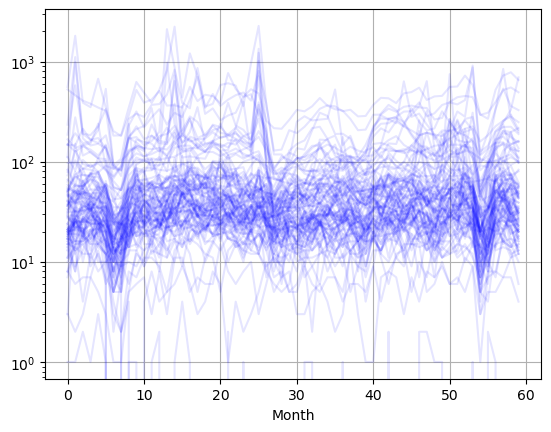

In [18]:
for i in range(ts.shape[0]):
    plt.plot(ts[i, :], alpha = 0.1, c = "blue")

plt.xlabel("Month")
plt.grid()
plt.yscale("log")
plt.show()

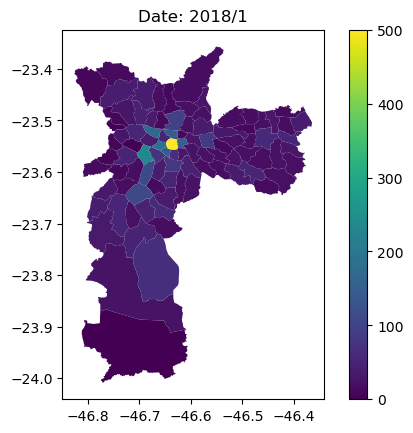

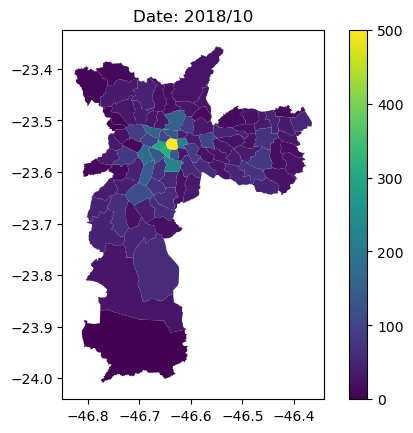

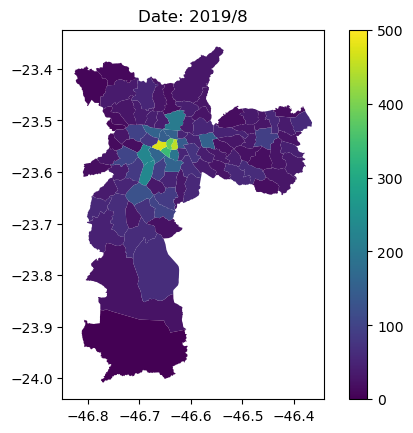

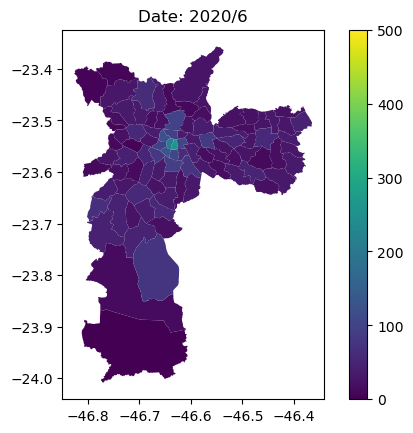

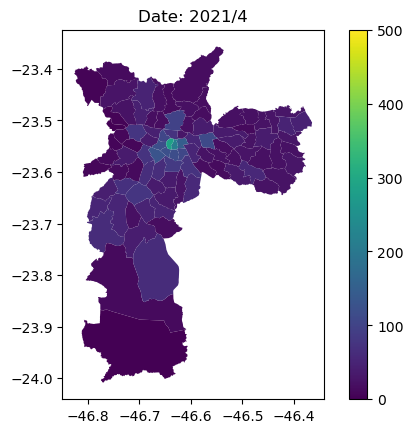

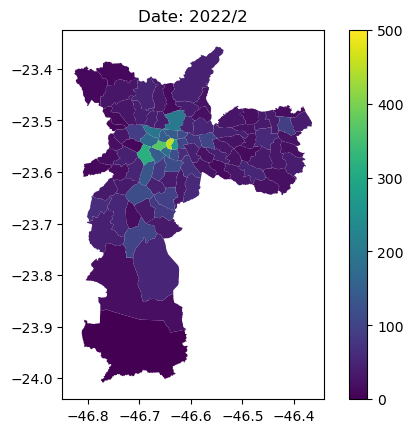

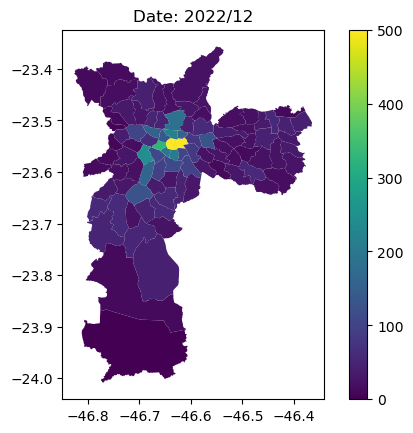

In [21]:
def mapper_int_to_date(i):
    year = 2018 + i // 12
    month = i % 12 + 1
    return f"{year}/{month}"

selected_dates = [0, 9, 19, 29, 39, 49, 59]
for d in selected_dates:
    shapes["count"] = ts[:, d]
    shapes.plot(column = "count", legend = True, vmin = 0, vmax = 500)
    plt.title(f"Date: {mapper_int_to_date(d)}")
    plt.show()

In [22]:
np.save("data/time_series/furto_celular_district.npy", ts)

In [23]:
df = pd.read_csv("data/time_series/roubo_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_397/1213486941.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/roubo_celular_2018_2022.csv", sep = ";")


(588122, 14)

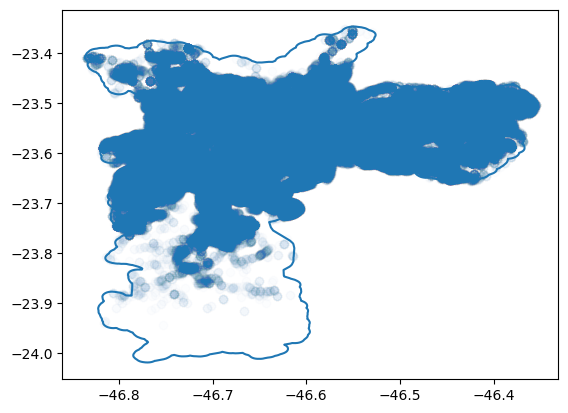

In [24]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha = 0.01)
plt.show()

In [25]:
shapes = gpd.read_file("data/LAYER_DISTRITO/sp.shp")

def get_polygon(row):
    point = Point(row['LONGITUDE'], row['LATITUDE'])
    contain = shapes.geometry.apply(lambda x: x.contains(point))
    if contain.any():
        return contain[contain].index[0]
    else:
        return None
    
df['district'] = df.progress_apply(get_polygon, axis = 1)

100%|██████████| 588122/588122 [12:23<00:00, 790.87it/s] 


In [26]:
df = df.dropna()

In [27]:
df["month_year"] = df.date.apply(lambda x : f"{x.year}/{x.month}")

In [28]:
grouped_alerts = df.groupby(["month_year", "district"]).size()
grouped_alerts = grouped_alerts.reset_index()
grouped_alerts.district = grouped_alerts.district.astype(int)
grouped_alerts = grouped_alerts.rename(columns = {0: "count"})
grouped_alerts

,month_year,district,count
0,2018/1,0,70
1,2018/1,1,142
2,2018/1,2,81
3,2018/1,3,23
4,2018/1,4,82
...,...,...,...
5732,2022/9,91,110
5733,2022/9,92,170
5734,2022/9,93,29
5735,2022/9,94,79


In [29]:
ts = np.zeros((len(shapes), 60))
k = 0
for year in range(2018, 2023):
    for month in range(1, 13):
        filtered = grouped_alerts[grouped_alerts.month_year == f"{year}/{month}"]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        else:
            # fill missing values with 0
            ts[:, k] = 0
            ts[filtered.district, k] = filtered["count"]
        k += 1

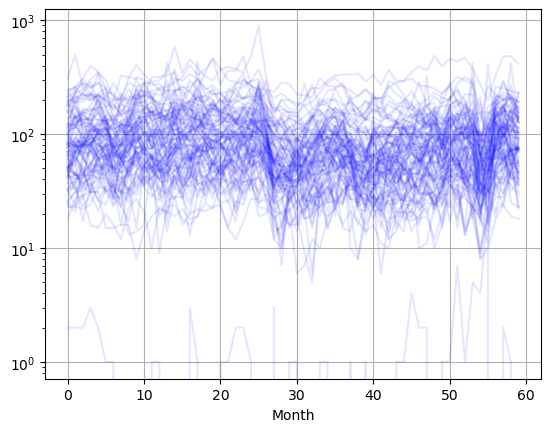

In [30]:
for i in range(ts.shape[0]):
    plt.plot(ts[i, :], alpha = 0.1, c = "blue")

plt.xlabel("Month")
plt.grid()
plt.yscale("log")
plt.show()

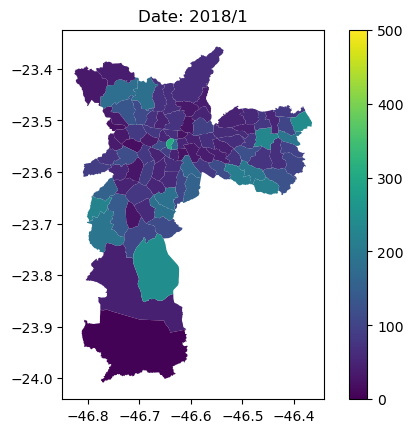

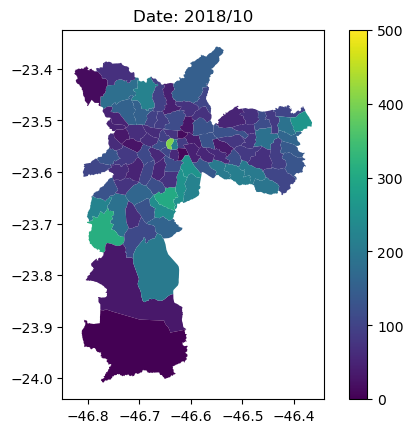

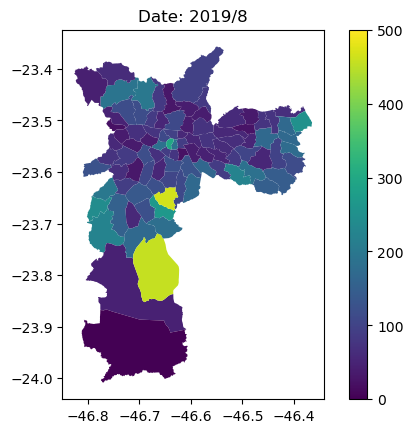

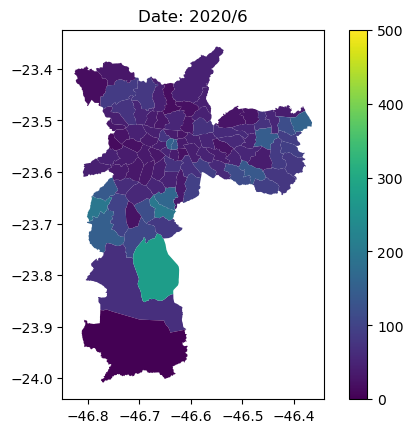

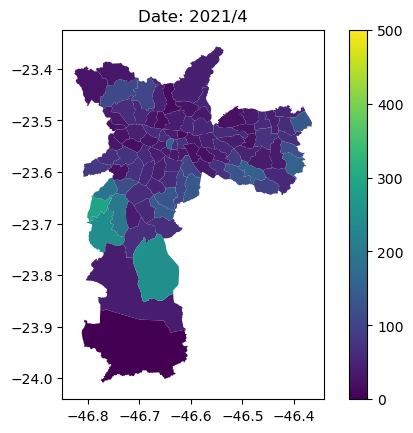

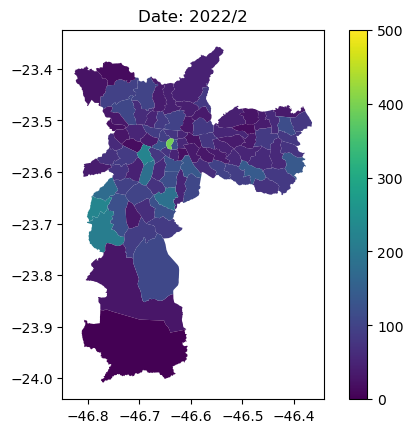

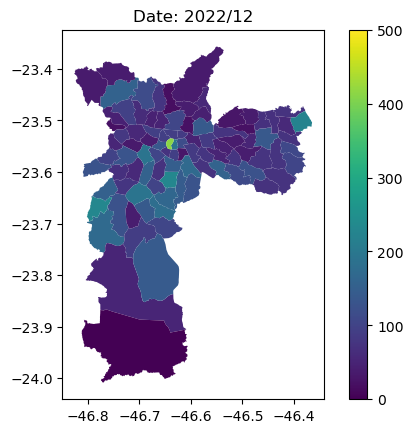

In [31]:
def mapper_int_to_date(i):
    year = 2018 + i // 12
    month = i % 12 + 1
    return f"{year}/{month}"

selected_dates = [0, 9, 19, 29, 39, 49, 59]
for d in selected_dates:
    shapes["count"] = ts[:, d]
    shapes.plot(column = "count", legend = True, vmin = 0, vmax = 500)
    plt.title(f"Date: {mapper_int_to_date(d)}")
    plt.show()

In [32]:
np.save("data/time_series/roubo_celular_district.npy", ts)